#Fake News Detection using Deep Learning


###Importing Libraries


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
import matplotlib.pyplot as plt

###Import Dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
real_data = pd.read_csv('/content/drive/My Drive/dataset/True.csv')
fake_data = pd.read_csv('/content/drive/My Drive/dataset/Fake.csv')

###Data Preprocessing:
(Same in all):
1. Reduce the number of rows to min of both
2. Add new field: real_data['category'] = 1, fake_data['category'] = 0
3. Merge two datasets


In [ ]:
'''
1. Reduce the number of rows to min of both
'''
print(len(real_data))
print(len(fake_data))

nb_articles = min(len(real_data), len(fake_data))
real_data = real_data[:nb_articles]
fake_data = fake_data[:nb_articles]

print(len(real_data))
print(len(fake_data))

21417
23481
21417
21417


In [ ]:
'''
2. 
'''
real_data['category'] = 1
fake_data['category'] = 0

In [ ]:
'''
3.
'''
df = pd.concat([real_data, fake_data])

# Shuffle the data
from sklearn.utils import shuffle
df = shuffle(df).reset_index(drop=True)
df.head()

,title,text,subject,date,category
0,Mark Zuckerberg Brutally SHAMES Trump For Cal...,"Recently, President Bannon s underling, Donald...",News,"February 21, 2017",0
1,Trump Just Blamed Bombings On ‘Freedom Of The...,Donald Trump appeared on Fox & Friends Monday ...,News,"September 19, 2016",0
2,U.N. nuclear chief to visit Iran this weekend,VIENNA (Reuters) - The head of the United Nati...,worldnews,"October 25, 2017",1
3,German political rivals agree: No lottery for me,BERLIN (Reuters) - German Chancellor Angela Me...,worldnews,"September 22, 2017",1
4,This One Car Could Overthrow The Governments ...,"For more than a century, countries around the ...",News,"April 1, 2016",0


###Data Preprocessing
Remaining Steps: (common for Kartik and Sparsh):
4. text = text + title
5. Data Cleaning
6. Data Analysis
7. Word Cloud

In [ ]:
#4
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

In [ ]:
#5. Data Cleaning:

# stop-words:
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['text']=df['text'].apply(denoise_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df.head()

,text,category
0,really hard LGBT community welcome Caitlyn Jen...,0
1,never young commit jihad Teachers primary scho...,0
2,Donald Trump might try tell American voters ch...,0
3,President Obama obviously disappointed Donald ...,0
4,BELGRADE (Reuters) British Foreign Secretary B...,1


####Data Analysis

In [ ]:
#6. Data Analysis:

from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
#Unigram:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

In [ ]:
#Bigram:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

In [ ]:
#Trigram:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

In [ ]:
# WORDCLOUD FOR REAL TEXT (LABEL - 1)
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
# WORDCLOUD FOR FAKE TEXT (LABEL - 0)
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

##Embeddings

###TF-IDF

In [ ]:
df_tfidf = df.copy()

In [ ]:
# Generating stemmed and lemmatized text for applying TF-IDF:
import nltk
nltk.download('wordnet')
from nltk.stem import PorterStemmer, WordNetLemmatizer

porter_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

stemmed_text = []
lemmatized_text = []
final_text_result = []
for text in df_tfidf['text']:
    result = re.sub('[^a-zA-Z]', ' ', text)
    # result = result.lower()
    result = result.split()
    # result = [r for r in result if r not in set(stopwords.words('english'))]
    stemmed_result = [porter_stemmer.stem(r) for r in result]
    stemmed_text.append(" ".join(stemmed_result))
    lemmatized_result = [lemmatizer.lemmatize(r) for r in result]
    lemmatized_text.append(" ".join(lemmatized_result))

print(len(stemmed_text))
print(len(lemmatized_text))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
42834
42834


In [ ]:
# function to print confusion matrix and accuracy score:
def get_prediction(vectorizer, classifier, X_train, X_test, y_train, y_test):
    pipe = Pipeline([('vector', vectorizer),
                    ('model', classifier)])
    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuarcy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: \n", cm)
    print("Classification Report: \n", classification_report(y_test, y_pred))

In [ ]:
# Importing Classifiers:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# TF-IDF Vectorizer:

# here we are taking only top 5000 words from the news
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
# TF-IDF feature matrix:
X_tfidf = tfidf_vectorizer.fit_transform(stemmed_text)
X_tfidf.shape

(42834, 5000)

In [ ]:
# Getting the target variable
y_tfidf = df_tfidf['category']

# Divide the dataset into Train and Test
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y_tfidf, test_size=0.25, random_state=0)

####One hot for Embedding layers and Padding


In [ ]:
from tensorflow.keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

#Setting up vocabulary size
voc_size = 10000

#One hot encoding 
onehot_repr_tfidf = [one_hot(words,voc_size)for words in stemmed_text] 

# Padding embedded documents - to make the length of all sentences equal
# Setting sentence length
sent_length=5000

#Padding the sentences
embedded_docs_tfidf = pad_sequences(onehot_repr_tfidf, padding='pre', maxlen = sent_length)
print(embedded_docs_tfidf)

[[   0    0    0 ... 3856 7381 5950]
 [   0    0    0 ... 2675 1238 3132]
 [   0    0    0 ... 4997 8851 9290]
 ...
 [   0    0    0 ... 2223 2837 5445]
 [   0    0    0 ... 3024  885 5559]
 [   0    0    0 ... 7861 4250 2460]]


##TF-IDF Vectorizer

###LSTM


In [ ]:
#Creating the lstm model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length = sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100)) #Adding 100 lstm neurons in the layer
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

#Compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 5000, 40)          400000    
                                                                 
 dropout_6 (Dropout)         (None, 5000, 40)          0         
                                                                 
 lstm_11 (LSTM)              (None, 100)               56400     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                 101       
                                                                 
Total params: 456,501
Trainable params: 456,501
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Fitting the LSTM Model
# Converting the X and y as array
X_tfidf_lstm = np.array(embedded_docs_tfidf)
y_tfidf_lstm = np.array(y_tfidf)

#Check shape of X and y final
X_tfidf_lstm.shape, y_tfidf_lstm.shape

# Train test split of the X and y final
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_lstm, y_tfidf_lstm, test_size=0.33, random_state=42)

In [ ]:
# Fitting with 10 epochs and 64 batch size
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,batch_size=64)

Epoch 1/5
449/449 [==============================] - 113s 248ms/step - loss: 0.1235 - accuracy: 0.9538 - val_loss: 0.0508 - val_accuracy: 0.9827
Epoch 2/5
449/449 [==============================] - 120s 267ms/step - loss: 0.0268 - accuracy: 0.9923 - val_loss: 0.0572 - val_accuracy: 0.9826
Epoch 3/5
449/449 [==============================] - 129s 287ms/step - loss: 0.0193 - accuracy: 0.9944 - val_loss: 0.0275 - val_accuracy: 0.9914
Epoch 4/5
449/449 [==============================] - 115s 255ms/step - loss: 0.0070 - accuracy: 0.9981 - val_loss: 0.0301 - val_accuracy: 0.9919
Epoch 5/5
449/449 [==============================] - 114s 254ms/step - loss: 0.0168 - accuracy: 0.9948 - val_loss: 0.0367 - val_accuracy: 0.9881


####Evaluation of LSTM

In [ ]:
# Predicting from test data
# tf.sparse.reorder(sp_input)
y_pred_tfidf = model.predict(X_test_tfidf)
y_classes_tfidf = np.argmax(y_pred_tfidf, axis=1)

#Creating confusion matrix
#confusion_matrix(y_test,y_pred)
cm = metrics.confusion_matrix(y_test_tfidf, y_pred_tfidf)
plot_confusion_matrix(cm,classes=['Fake','True'])

InvalidArgumentError: ignored

###RNN Model

In [ ]:
model_RNN = tf.keras.Sequential([
    tf.keras.layers.Embedding(voc_size, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model_RNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [ ]:
# We are going to use early stop, which stops when the validation loss no longer improve
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_RNN.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history_RNN_tfidf = model_RNN.fit(X_train, y_train, epochs=10,validation_data=(X_test,y_test), batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
957/957 [==============================] - 566s 586ms/step - loss: 0.2055 - accuracy: 0.9030 - val_loss: 0.0347 - val_accuracy: 0.9924
Epoch 2/10
957/957 [==============================] - 565s 590ms/step - loss: 0.0323 - accuracy: 0.9933 - val_loss: 0.0376 - val_accuracy: 0.9883
Epoch 3/10
957/957 [==============================] - 563s 589ms/step - loss: 0.0179 - accuracy: 0.9962 - val_loss: 0.0212 - val_accuracy: 0.9949
Epoch 4/10
957/957 [==============================] - 571s 596ms/step - loss: 0.0085 - accuracy: 0.9988 - val_loss: 0.0192 - val_accuracy: 0.9953
Epoch 5/10
957/957 [==============================] - 572s 598ms/step - loss: 0.0059 - accuracy: 0.9992 - val_loss: 0.0185 - val_accuracy: 0.9955
Epoch 6/10
957/957 [==============================] - 572s 598ms/step - loss: 0.0054 - accuracy: 0.9992 - val_loss: 0.0223 - val_accuracy: 0.9957
Epoch 7/10
957/957 [==============================] - 573s 598ms/step - loss: 0.0083 - accuracy: 0.9986 - val_loss: 0.0317 -

####Visualize our training over time (RNN)

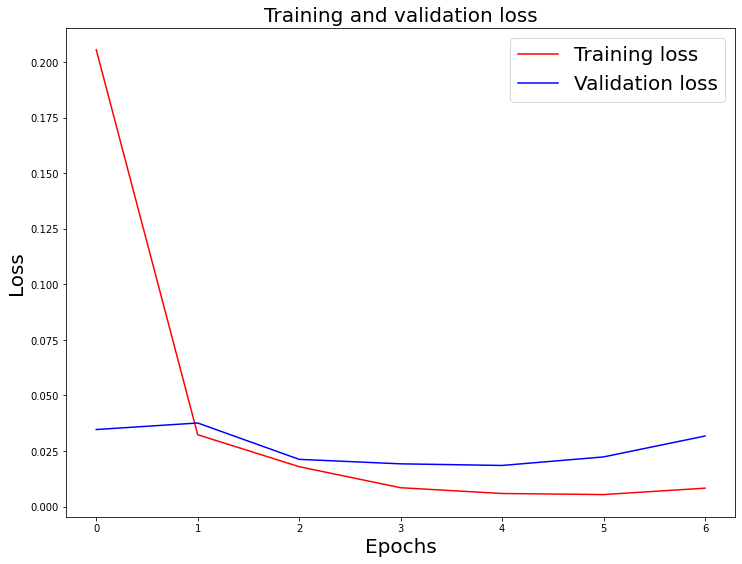

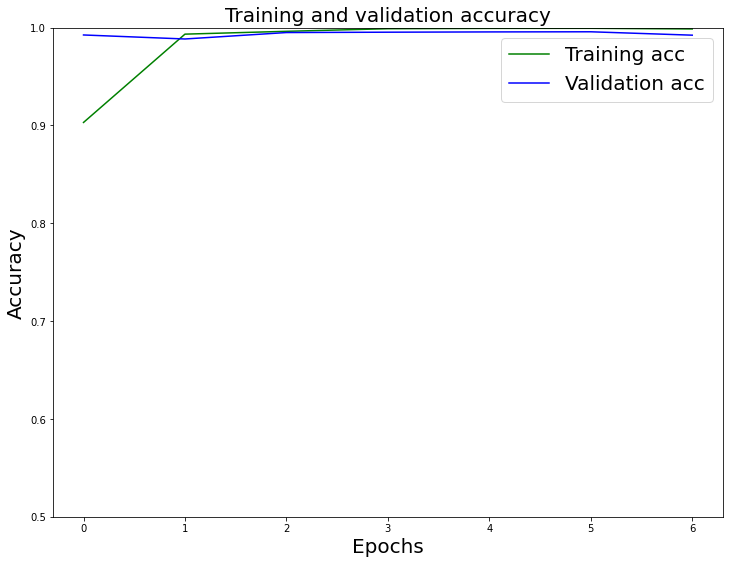

In [ ]:
history_dict_RNN_tfidf = history_RNN_tfidf.history

acc = history_dict_RNN_tfidf['accuracy']
val_acc = history_dict_RNN_tfidf['val_accuracy']
loss = history_dict_RNN_tfidf['loss']
val_loss = history_dict_RNN_tfidf['val_loss']
epochs = history_RNN_tfidf.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

###CNN

In [ ]:
# Define the model:
model_CNN = Sequential()
model_CNN.add(Dense(units = 100 , activation = 'relu' , input_dim = X_tfidf.shape[1]))
model_CNN.add(Dense(units = 50 , activation = 'relu'))
model_CNN.add(Dense(units = 25 , activation = 'relu'))
model_CNN.add(Dense(units = 10 , activation = 'relu'))
model_CNN.add(Dense(units = 1 , activation = 'sigmoid'))

In [ ]:
# Compile the model:
model_CNN.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [ ]:
# Fit the model
model_CNN.fit(X_train,y_train , epochs = 5)

Epoch 1/5
897/897 [==============================] - 4s 3ms/step - loss: 1.8875 - accuracy: 0.4974
Epoch 2/5
897/897 [==============================] - 3s 3ms/step - loss: 0.6932 - accuracy: 0.4981
Epoch 3/5
897/897 [==============================] - 3s 3ms/step - loss: 0.6932 - accuracy: 0.4989
Epoch 4/5
897/897 [==============================] - 3s 3ms/step - loss: 0.6932 - accuracy: 0.4992
Epoch 5/5
897/897 [==============================] - 3s 3ms/step - loss: 0.6932 - accuracy: 0.4974


####Prediction - CNN

In [ ]:
pred_tfidf_CNN = model_CNN.predict(X_test)
print(pred_tfidf_CNN)
prede_tfidf_CNN = list()
for i in range(len(pred_tfidf_CNN)):
    if(pred_tfidf_CNN[i] > 0.5):
        prede_tfidf_CNN.append(1)
    else:
        prede_tfidf_CNN.append(0)
print(prede_tfidf_CNN)
accuracy_score(prede_tfidf_CNN,y_test)

[[0.49662206]
 [0.49662206]
 [0.49662206]
 ...
 [0.49662206]
 [0.49662206]
 [0.49662206]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

0.49787775891341257

####Evaluation of CNN

In [ ]:
tfidf_cnn_report = classification_report(y_test,pred_tfidf_CNN,target_names = ['0','1'])
print(tfidf_cnn_report)

              precision    recall  f1-score   support

           0       0.50      1.00      0.66      7038
           1       0.00      0.00      0.00      7098

    accuracy                           0.50     14136
   macro avg       0.25      0.50      0.33     14136
weighted avg       0.25      0.50      0.33     14136



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


####Confusion Matrix for CNN

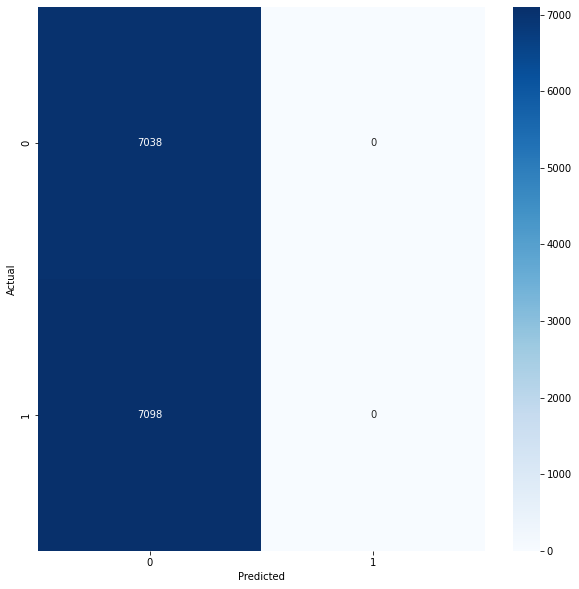

In [ ]:
cm_tfidf_cnn = confusion_matrix(y_test,pred_tfidf_CNN)
cm_tfidf_cnn = pd.DataFrame(cm_tfidf_cnn, index=[0,1], columns=[0,1])
cm_tfidf_cnn.index.name = 'Actual'
cm_tfidf_cnn.columns.name = 'Predicted'
plt.figure(figsize = (10,10))
sns.heatmap(cm_tfidf_cnn,cmap= "Blues",annot = True, fmt='')

#Glove


In [ ]:
df_glove = df.copy()

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(df_glove.text,df_glove.category,random_state = 0)
max_features = 10000
maxlen = 300

In [ ]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [ ]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [ ]:
EMBEDDING_FILE = '/content/drive/My Drive/dataset/glove.twitter.27B.100d.txt'

In [ ]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [ ]:
# Creating a copy of train and test data for genetic:
x_test_ga = X_test
x_train_ga = x_train
y_ga = y_train

##LSTM on Glove

In [ ]:
batch_size = 256
epochs = 1
embed_size = 100

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 300, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

126/126 [==============================] - 333s 3s/step - loss: 0.1201 - accuracy: 0.9548 - val_loss: 0.0260 - val_accuracy: 0.9911 - lr: 0.0100


In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

 566/1004 [===============>..............] - ETA: 1:09 - loss: 0.0248 - accuracy: 0.9919

KeyboardInterrupt: ignored

ValueError: ignored

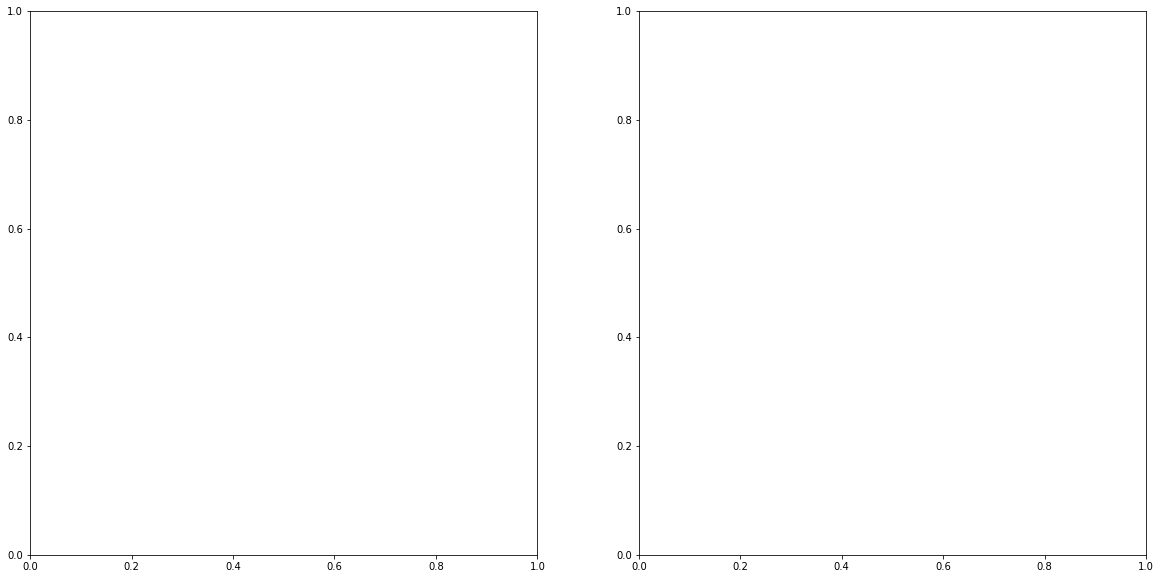

In [ ]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
pred = model.predict(X_test)

In [ ]:
classe_x = list()
for i in pred:
  if i[0] >= 0.5:
    classe_x.append(1)
  else:
    classe_x.append(0)
classe_x

[0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,


In [ ]:
print(classification_report(y_test, classe_x, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      5360
    Not Fake       0.99      0.99      0.99      5349

    accuracy                           0.99     10709
   macro avg       0.99      0.99      0.99     10709
weighted avg       0.99      0.99      0.99     10709



In [ ]:
cm = confusion_matrix(y_test, classe_x)
cm

array([[5320,   40],
       [  55, 5294]])

In [ ]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])
cm

,Fake,Original
Fake,5320,40
Original,55,5294


Text(69.0, 0.5, 'Actual')

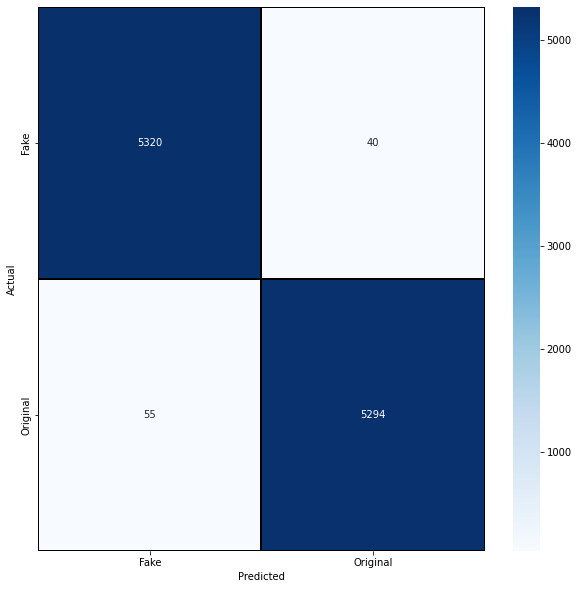

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

##RNN on Glove

In [ ]:
voc_size = 10000
model_RNN = tf.keras.Sequential([
    tf.keras.layers.Embedding(voc_size, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model_RNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

x_train = normalize(x_train)
x_test = normalize(x_test)

AttributeError: ignored

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(x_train)

In [ ]:
X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [ ]:
model_RNN = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model_RNN.summary()

In [ ]:
# We are going to use early stop, which stops when the validation loss no longer improve
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_RNN.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history_RNN_glove = model_RNN.fit(X_train, y_train, epochs=1,validation_data=(x_test,y_test), batch_size=30, shuffle=True, callbacks=[early_stop])

In [ ]:
def train_evaluate(ga_individual_solution):  
    
    # Decode the Genetic Algorithm solution to get the window size and number of bits
    window_size_bits = BitArray(ga_individual_solution[0:6])
    num_units_bits = BitArray(ga_individual_solution[6:]) 
    window_size = window_size_bits.uint
    num_of_units = num_units_bits.uint
    print('\nWindow Size: ', window_size, ', Num of Units: ', num_of_units)
    
    # Return fitness score of 100 if window_size or num_unit is zero
    if window_size == 0 or num_of_units == 0:
        return 100, 
    
    # Segment the train_data based on new window_size; 
    # Split the dataset into train set(80) and validation set(20)
    X_data,Y_data = prepare_dataset(x_train,window_size)
    X_train, X_val, y_train, y_val = split(X_data, Y_data, test_size = 0.20, random_state = 1120)
    
    # Design an LSTM model to train on training data and predict on validation data
    input_ph = Input(shape=(window_size,1))
    x = LSTM(num_of_units, input_shape=(window_size,1))(input_ph)
    predicted_values = Dense(1, activation='tanh')(x)
    model = Model(inputs=input_ph, outputs=predicted_values)
    model.compile(optimizer='adam',loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=5, batch_size=20,shuffle=True)
    y_pred = model.predict(X_val)
    
    # Calculate the RMSE score as fitness score for GA
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print('Validation RMSE: ', rmse,'\n')
    
    return rmse

In [ ]:
def prepare_dataset(data, window_size):
    X, Y = np.empty((0,window_size)), np.empty((0))
    for i in range(len(data)-window_size-1):
        X = np.vstack([X,data[i:(i + window_size),0]])
        Y = np.append(Y,data[i + window_size,0])   
    X = np.reshape(X,(len(X),window_size,1))
    Y = np.reshape(Y,(len(Y),1))
    return X, Y

population_size = 4
num_generations = 4
gene_length = 10

#Implementation of Genetic Algorithm using DEAP python library.

#Since we try to minimise the loss values, we use the negation of the root mean squared loss as fitness function.
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

#initialize the variables as bernoilli random variables
toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

#Ordered cross-over used for mating
toolbox.register('mate', tools.cxOrdered)
#Shuffle mutation to reorder the chromosomes
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
#use roulette wheel selection algorithm
toolbox.register('select', tools.selRoulette)
#training function used for evaluating fitness of individual solution.
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, ngen = num_generations, verbose = False)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)



Window Size:  37 , Num of Units:  12
Epoch 1/5
1284/1284 [==============================] - 8s 4ms/step - loss: 1554564.8750
Epoch 2/5
1284/1284 [==============================] - 6s 4ms/step - loss: 1554539.2500
Epoch 3/5
1284/1284 [==============================] - 8s 6ms/step - loss: 1554539.7500
Epoch 4/5
1284/1284 [==============================] - 8s 6ms/step - loss: 1554539.1250
Epoch 5/5
1284/1284 [==============================] - 6s 4ms/step - loss: 1554539.5000
Validation RMSE:  1173.2752533631021 



TypeError: ignored

In [ ]:
optimal_individuals_data = tools.selBest(population,k = 1) #select top 1 solution
optimal_window_size = None
optimal_num_units = None

for bi in optimal_individuals_data:
    window_size_bits = BitArray(bi[0:6])
    num_units_bits = BitArray(bi[6:]) 
    optimal_window_size = window_size_bits.uint
    optimal_num_units = num_units_bits.uint
    print('\n Best Window Size: ', optimal_window_size, ', Best Num of Units: ', optimal_num_units)

#print(optimal_window_size, optimal_num_units)

In [ ]:
import numpy as np
from keras.layers import LSTM, Input, Dense
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as split
!pip install deap
from deap import base, creator, tools, algorithms
from keras.models import Model
from scipy.stats import bernoulli
#import tflearn
#from tflearn.metrics import Accuracy
!pip install bitstring
from bitstring import BitArray

np.random.seed(1120)

def prepare(data, win_size):
    A, B = np.empty((0,win_size)), np.empty((0))
    for i in range(len(data)-win_size-1):
        A = np.vstack([A,data[i:(i + win_size),0]])
        B = np.append(B,data[i + win_size,0])   
    A = np.reshape(A,(len(A),win_size,1))
    B = np.reshape(B,(len(B),1))
    return A, B

def evaluate(ga_sol):       
    win_size_bits = BitArray(ga_sol[0:6])
    number_units_bits = BitArray(ga_sol[6:]) 
    win_size = win_size_bits.uint
    number_units = number_units_bits.uint
    print('\nWindow Size: ', win_size, ', Num of Units: ', number_units)
    
    
    if win_size == 0 or number_units == 0:
        return 100, 
    
    
    A,B = prepare(x_train,win_size)
    A_train, A_val, B_train, B_val = split(A, B, test_size = 0.20, random_state = 1120)
    
    
    inputs = Input(shape=(win_size,1))
    A = LSTM(number_units, input_shape=(win_size,1))(inputs)
    predictions = Dense(1, activation='relu')(A)
    model = Model(inputs=inputs, outputs=predictions)
    #model = tflearn.DNN(predictions, tensorboard_verbose=3, tensorboard_dir="logs")
    model.compile(optimizer='adam',loss='mean_squared_error')
    model.fit(A_train, B_train, epochs=5, batch_size=10,shuffle=True)
    B_pred = model.predict(A_val)
    #model.save('./ZtrainedNet/final-model.tfl')      
    rmse = np.sqrt(mean_squared_error(B_val, B_pred))
    print('Validation RMSE: ', rmse,'\n')    
    return rmse,

population_size = 10
num_generations = 5
gene_length = 12

creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpbb = 0.6)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', evaluate)


population = toolbox.population(n = population_size)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, ngen = num_generations, verbose = False)


best_individuals = tools.selBest(population,k = 1)
best_win_size = None
best_number_units = None

for bi in best_individuals:
    win_size_bits = BitArray(bi[0:6])
    number_units_bits = BitArray(bi[6:]) 
    best_win_size = win_size_bits.uint
    best_number_units = number_units_bits.uint
    print('\nWindow Size: ', best_win_size, ', Num of Units: ', best_number_units)


A_train,B_train = prepare(x_train,best_win_size)
A_test, B_test = prepare(X_test,best_win_size)

inputs = Input(shape=(best_win_size,1))
A = LSTM(best_number_units, input_shape=(best_win_size,1))(inputs)
predictions = Dense(1, activation='relu')(A)
model = Model(inputs = inputs, outputs = predictions)
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(A_train, B_train, epochs=5, batch_size=10,shuffle=True)
B_pred = model.predict(A_test)

rmse = np.sqrt(mean_squared_error(B_test, B_pred))
print('Test RMSE: ', rmse)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)



Window Size:  36 , Num of Units:  11
Epoch 1/5
2567/2567 [==============================] - 13s 4ms/step - loss: 1473231.3750
Epoch 2/5
2567/2567 [==============================] - 9s 4ms/step - loss: 1459484.3750
Epoch 3/5
2567/2567 [==============================] - 9s 4ms/step - loss: 1447928.5000
Epoch 4/5
2567/2567 [==============================] - 9s 4ms/step - loss: 1437464.1250
Epoch 5/5
2567/2567 [==============================] - 10s 4ms/step - loss: 1428146.3750
Validation RMSE:  1266.63667768132 


Window Size:  34 , Num of Units:  15
Epoch 1/5
2568/2568 [==============================] - 68s 4ms/step - loss: 1524133.8750
Epoch 2/5
2568/2568 [==============================] - 11s 4ms/step - loss: 1524134.0000
Epoch 3/5
2568/2568 [==============================] - 11s 4ms/step - loss: 1524132.3750
Epoch 4/5
2568/2568 [==============================] - 11s 4ms/step - loss: 1524133.8750
Epoch 5/5
2568/2568 [==============================] - 11s 4ms/step - loss: 1524131.6250


TypeError: ignored

#Genetic Algorithm


In [ ]:
!pip install deap
!pip install bitstring
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as split

from keras.layers import LSTM, Input, Dense
from keras.models import Model

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray

np.random.seed(1120)

In [ ]:
# x_test_ga = X_test
# x_train_ga -> train_data
# y_ga = y_train

def prepare_dataset(data, window_size):
    X, Y = np.empty((0,window_size)), np.empty((0))
    for i in range(len(data)-window_size-1):
        X = np.vstack([X,data[i:(i + window_size),0]])
        Y = np.append(Y,data[i + window_size,0])   
    X = np.reshape(X,(len(X),window_size,1))
    Y = np.reshape(Y,(len(Y),1))
    return X, Y

X_train,y_train = prepare_dataset(x_train_ga, 3)
print(X_train)
print(y_train)

[[[   0.]
  [   0.]
  [   0.]]

 [[   0.]
  [   0.]
  [   0.]]

 [[   0.]
  [   0.]
  [ 576.]]

 ...

 [[   0.]
  [1135.]
  [   0.]]

 [[1135.]
  [   0.]
  [   0.]]

 [[   0.]
  [   0.]
  [   0.]]]
[[  0.]
 [576.]
 [  0.]
 ...
 [  0.]
 [  0.]
 [429.]]


In [ ]:
def train_evaluate(ga_individual_solution):  
    
    # Decode the Genetic Algorithm solution to get the window size and number of bits
    window_size_bits = BitArray(ga_individual_solution[0:6])
    num_units_bits = BitArray(ga_individual_solution[6:]) 
    window_size = window_size_bits.uint
    num_of_units = num_units_bits.uint
    print('\nWindow Size: ', window_size, ', Num of Units: ', num_of_units)
    
    # Return fitness score of 100 if window_size or num_unit is zero
    if window_size == 0 or num_of_units == 0:
        return 100, 
    
    # Segment the train_data based on new window_size; 
    # Split the dataset into train set(80) and validation set(20)
    X_data,Y_data = prepare_dataset(x_train_ga,window_size)
    X_train, X_val, y_train, y_val = train_test_split(X_data, Y_data, test_size = 0.20, random_state = 1120)
    
    # Design an LSTM model to train on training data and predict on validation data
    input_ph = Input(shape=(window_size,1))
    x = LSTM(num_of_units, input_shape=(window_size,1))(input_ph)
    predicted_values = Dense(1, activation='tanh')(x)
    model = Model(inputs=input_ph, outputs=predicted_values)
    model.compile(optimizer='adam',loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=5, batch_size=20,shuffle=True)
    y_pred = model.predict(X_val)
    
    # Calculate the RMSE score as fitness score for GA
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print('Validation RMSE: ', rmse,'\n')
    
    return rmse,

In [ ]:
population_size = 4
num_generations = 4
gene_length = 10

#Implementation of Genetic Algorithm using DEAP python library.

#Since we try to minimise the loss values, we use the negation of the root mean squared loss as fitness function.
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

#initialize the variables as bernoilli random variables
toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

#Ordered cross-over used for mating
toolbox.register('mate', tools.cxOrdered)
#Shuffle mutation to reorder the chromosomes
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
#use roulette wheel selection algorithm
toolbox.register('select', tools.selRoulette)
#training function used for evaluating fitness of individual solution.
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, ngen = num_generations, verbose = False)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)



Window Size:  36 , Num of Units:  2
Epoch 1/5
1284/1284 [==============================] - 11s 4ms/step - loss: 1580696.5000
Epoch 2/5
1284/1284 [==============================] - 5s 4ms/step - loss: 1580484.2500
Epoch 3/5
1284/1284 [==============================] - 5s 4ms/step - loss: 1580432.8750
Epoch 4/5
1284/1284 [==============================] - 5s 4ms/step - loss: 1580425.2500
Epoch 5/5
1284/1284 [==============================] - 5s 4ms/step - loss: 1580424.7500
Validation RMSE:  1234.4465291289002 


Window Size:  56 , Num of Units:  8
Epoch 1/5
1283/1283 [==============================] - 8s 5ms/step - loss: 1584165.2500
Epoch 2/5
1283/1283 [==============================] - 6s 4ms/step - loss: 1584066.7500
Epoch 3/5
1283/1283 [==============================] - 6s 4ms/step - loss: 1584066.0000
Epoch 4/5
1283/1283 [==============================] - 6s 4ms/step - loss: 1584065.7500
Epoch 5/5
1283/1283 [==============================] - 6s 4ms/step - loss: 1584066.8750
Valida

In [ ]:
optimal_individuals_data = tools.selBest(population,k = 1) #select top 1 solution
optimal_window_size = None
optimal_num_units = None

for bi in optimal_individuals_data:
    window_size_bits = BitArray(bi[0:6])
    num_units_bits = BitArray(bi[6:]) 
    optimal_window_size = window_size_bits.uint
    optimal_num_units = num_units_bits.uint
    print('\n Best Window Size: ', optimal_window_size, ', Best Num of Units: ', optimal_num_units)


 Best Window Size:  36 , Best Num of Units:  10


In [ ]:
#hence train the model with the optimal number of lstm units and optimal window size for prediction
X_train,y_train = prepare_dataset(x_train_ga,optimal_window_size)
X_test, y_test = prepare_dataset(x_train_ga,optimal_window_size)

inputs = Input(shape=(optimal_window_size,1))
x = LSTM(optimal_num_units, input_shape=(optimal_window_size,1))(inputs)
predictions = Dense(1, activation='tanh')(x)
model = Model(inputs = inputs, outputs = predictions)
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train, y_train, epochs=5, batch_size=20,shuffle=True)
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: ', rmse)

Epoch 1/5
1605/1605 [==============================] - 8s 4ms/step - loss: 1569169.5000
Epoch 2/5
1605/1605 [==============================] - 7s 4ms/step - loss: 1569111.8750
Epoch 3/5
1605/1605 [==============================] - 6s 4ms/step - loss: 1569111.0000
Epoch 4/5
1605/1605 [==============================] - 7s 4ms/step - loss: 1569110.0000
Epoch 5/5
1605/1605 [==============================] - 6s 4ms/step - loss: 1569109.8750
Test RMSE:  1252.6414063535658
